In [2]:
import lammps
import random
from tqdm import trange
import pymc3 as pm
import arviz as az
import numpy as np
import pymatgen as pmg
import theano.tensor as tt

# Initialisation
Create a lammps instance and load coordinates.

In [3]:
elements = pmg.Element('F'), pmg.Element('O'), pmg.Element('Li'), pmg.Element('Mn')
f, o, li, mn = elements

pairs = [(f,f), (f,o), (f,li), (f,mn), (o,o), (o,li), (o,mn)]

bpp_def = {'F_F_A': 417.063,
'F_F_rho': 0.318,
'F_F_C': 10.166,
'F_O_A' : 202.726,
'F_O_rho': 0.112,
'F_O_C' : 15.110,
'F_Li_A' : 612.519,
'F_Li_rho' : 0.254,
'F_Li_C' : 0.0,
'F_Mn_A' : 317.190,
'F_Mn_rho': 0.379,
'F_Mn_C' : 0.0,
'O_O_A' : 22764.7000,
'O_O_rho' : 0.1490,
'O_O_C' : 20.765,
'O_Li_A' : 632.1018,
'O_Li_rho' : 0.2906,
'O_Li_C' : 0.0,
'O_Mn_A' : 1273.669,
'O_Mn_rho' : 0.333,
'O_Mn_C' : 0.0}


bpp = {'F_F_A': 417.063,
'F_F_rho': 0.318,
'F_F_C': 10.166,
'F_O_A' : 202.726,
'F_O_rho': 0.112,
'F_O_C' : 15.110,
'F_Li_A' : 612.519,
'F_Li_rho' : 0.254,
'F_Li_C' : 0.0,
'F_Mn_A' : 317.190,
'F_Mn_rho': 0.379,
'F_Mn_C' : 0.0,
'O_O_A' : 22764.7000,
'O_O_rho' : 0.1490,
'O_O_C' : 20.765,
'O_Li_A' : 632.1018,
'O_Li_rho' : 0.2906,
'O_Li_C' : 0.0,
'O_Mn_A' : 1273.669,
'O_Mn_rho' : 0.333,
'O_Mn_C' : 0.0}


charges = {
    f: -1,
    o: -2,
    li: 1,
    mn: 3
}
def dex(elin): return elements.index(elin) + 1

In [7]:
def update_potentials(**kwargs):
    bpp.update(kwargs)
def set_potentials():
    for pair in pairs:
        lmp.command('pair_coeff {} {} {} {} {}'.format(dex(pair[0]),dex(pair[1]),
                                                       bpp['{}_{}_A'.format(pair[0], pair[1])],
                                                       bpp['{}_{}_rho'.format(pair[0], pair[1])],
                                                       bpp['{}_{}_C'.format(pair[0], pair[1])]
                                                      )
                   )

In [8]:
def init():
    lmp = lammps.Lammps(units='metal', style = 'full', args=['-log', 'none', '-screen', 'none'])
    lmp.command('read_data wagyu.beef')
    lmp.command('kspace_style pppm 1e-6')
    lmp.command('pair_style buck/coul/long 12.0')
    lmp.command('pair_coeff * * 0 1 0')

    for c in charges:
        lmp.command('set atom %d charge %f' % (elements.index(c)+1, charges[c]))
        
    return lmp

In [9]:
def simfunc(**kwargs):
    if min(kwargs.values()) > 0:
        update_potentials(**kwargs)
        set_potentials()
        lmp.run(0)
        out = lmp.system.forces
    else: out = np.ones([lmp.system.total,3])*999999999 # ThisAlgorithmBecomingSkynetCost
    return out

In [10]:
lmp = init()
with pm.Model() as model:

    F_F_A      = pm.Normal("F_F_A",    mu = bpp_def['F_F_A'],    sd =  50)
    F_F_rho    = pm.Normal("F_F_rho",  mu = bpp_def['F_F_rho'],  sd =  0.1)
    F_F_C      = pm.Normal("F_F_C",    mu = bpp_def['F_F_C'],    sd =  2)
    F_O_A      = pm.Normal("F_O_A",    mu = bpp_def['F_O_A'],    sd =  30)
    F_O_rho    = pm.Normal("F_O_rho",  mu = bpp_def['F_O_rho'],  sd =  0.025)
    F_O_C      = pm.Normal("F_O_C",    mu = bpp_def['F_O_C'],    sd =  2)
    F_Li_A     = pm.Normal("F_Li_A",   mu = bpp_def['F_Li_A'],   sd =  50)
    F_Li_rho   = pm.Normal("F_Li_rho", mu = bpp_def['F_Li_rho'], sd =  0.05)
    F_Mn_A     = pm.Normal("F_Mn_A",   mu = bpp_def['F_Mn_A'],   sd =  50)
    F_Mn_rho   = pm.Normal("F_Mn_rho", mu = bpp_def['F_Mn_rho'], sd =  0.1)
    O_O_C      = pm.Normal("O_O_C",    mu = bpp_def['O_O_C'],    sd =  5)
    O_Li_A     = pm.Normal("O_Li_A",   mu = bpp_def['O_Li_A'],   sd =  100)
    O_Li_rho   = pm.Normal("O_Li_rho", mu = bpp_def['O_Li_rho'], sd =  0.1)
    O_Mn_A     = pm.Normal("O_Mn_A",   mu = bpp_def['O_Mn_A'],   sd =  50)
    O_Mn_rho   = pm.Normal("O_Mn_rho", mu = bpp_def['O_Mn_rho'], sd =  0.025)
    
    simulator = pm.Simulator('simulator', simfunc, observed=np.zeros([lmp.system.total, 3]))
    
    trace = pm.sample(step=pm.SMC(ABC=True, epsilon=0.1), draws=1000)

Sample initial stage: ...
/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pymc3/step_methods/smc.py:176: UserWarning: Warning: SMC-ABC methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Stage: 0 Beta: 0.012 Steps: 25
Stage: 1 Beta: 0.043 Steps: 25
Stage: 2 Beta: 0.103 Steps: 2
Stage: 3 Beta: 0.220 Steps: 25
Stage: 4 Beta: 0.469 Steps: 2
Stage: 5 Beta: 0.979 Steps: 20
Stage: 6 Beta: 1.000 Steps: 3


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e1d7eb8>,
      dtype=object)

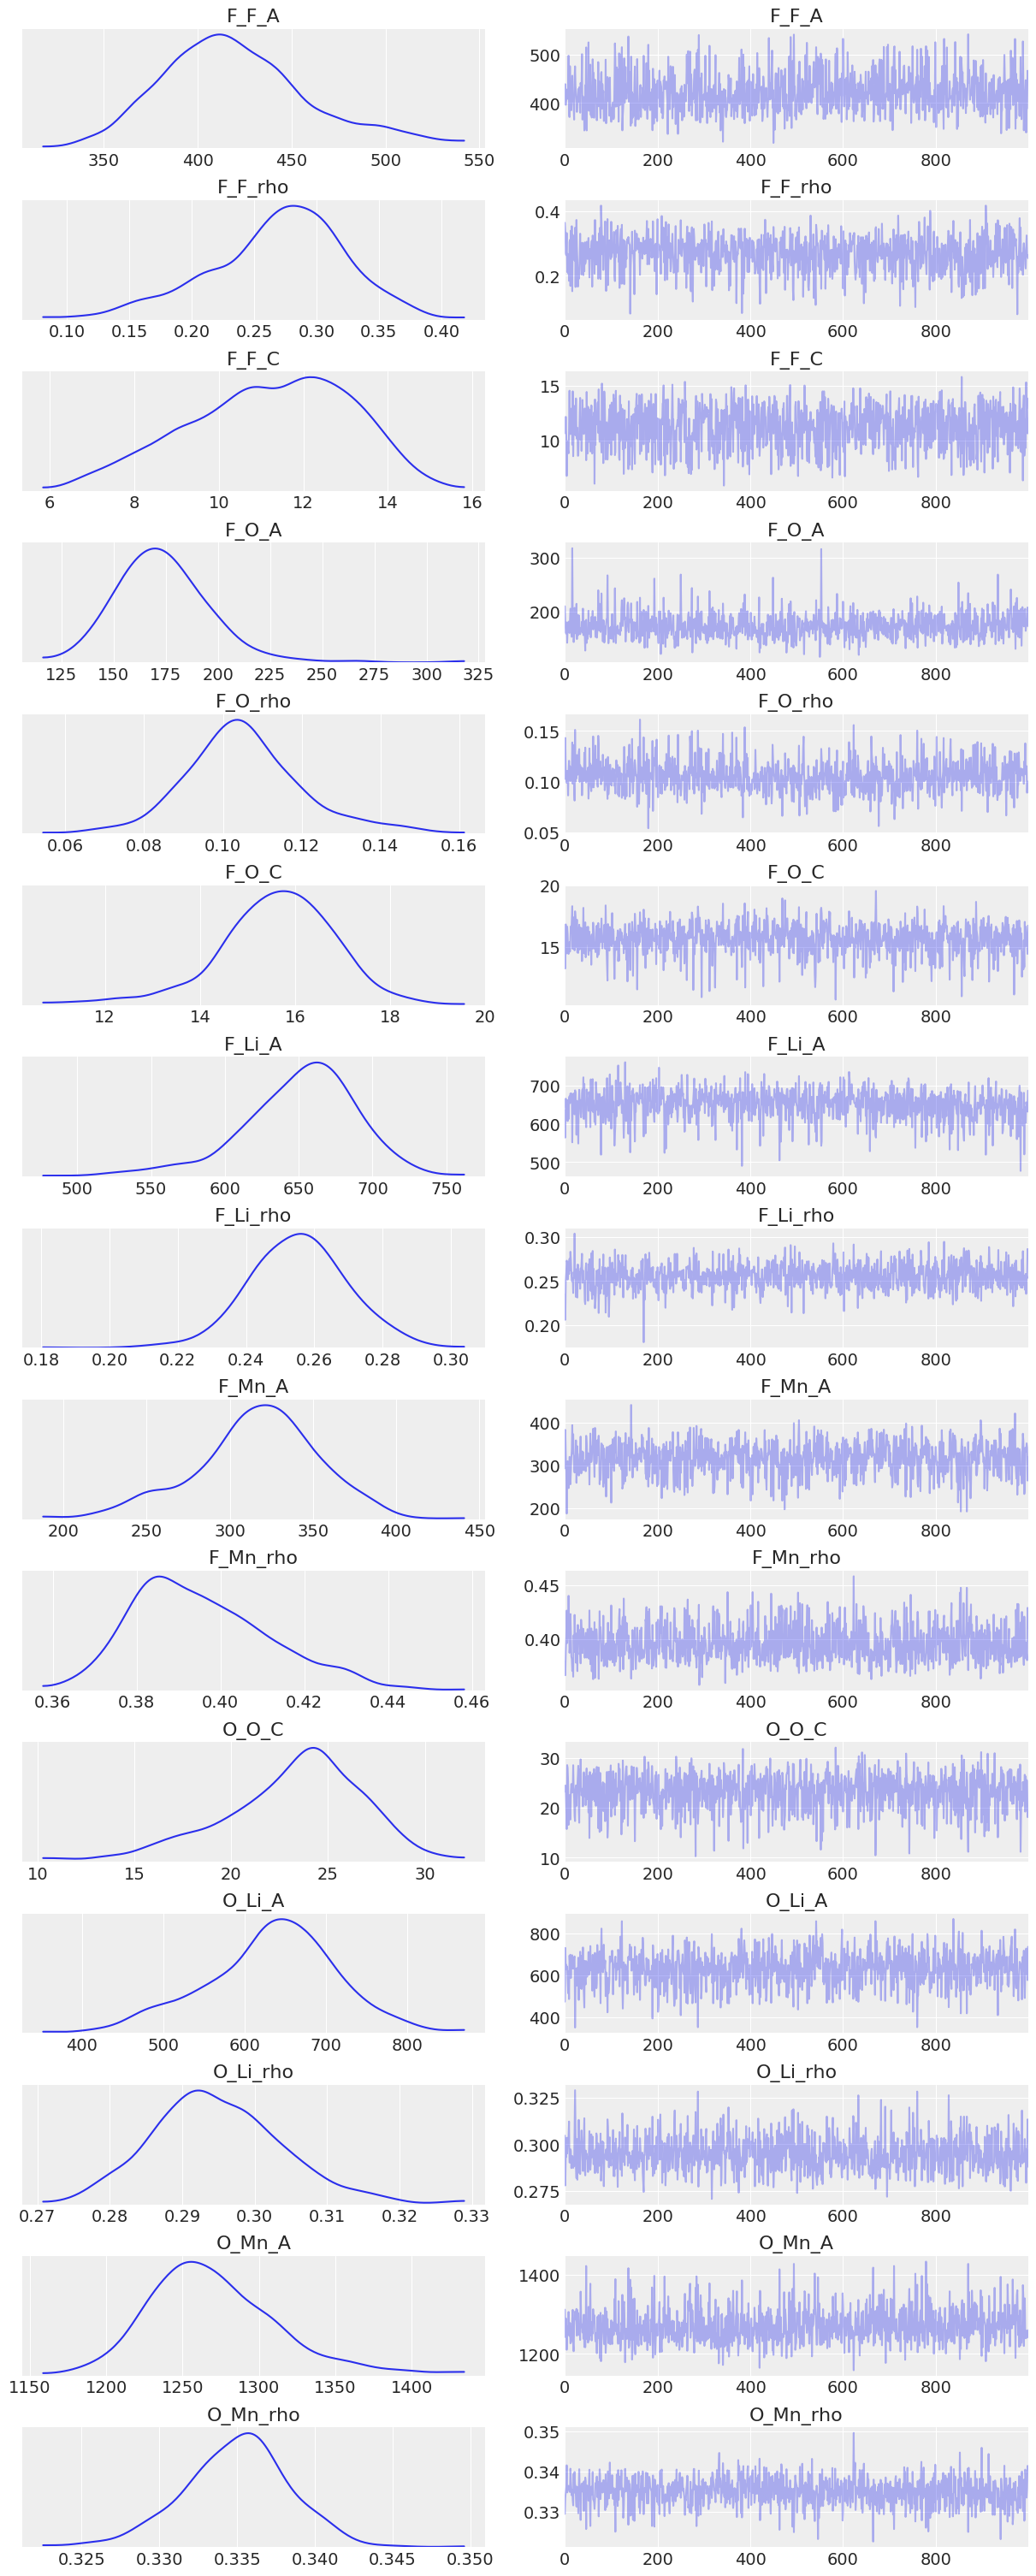

In [13]:
az.style.use('arviz-darkgrid')
az.plot_trace(trace)

/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x132352e48>,
      dtype=object)

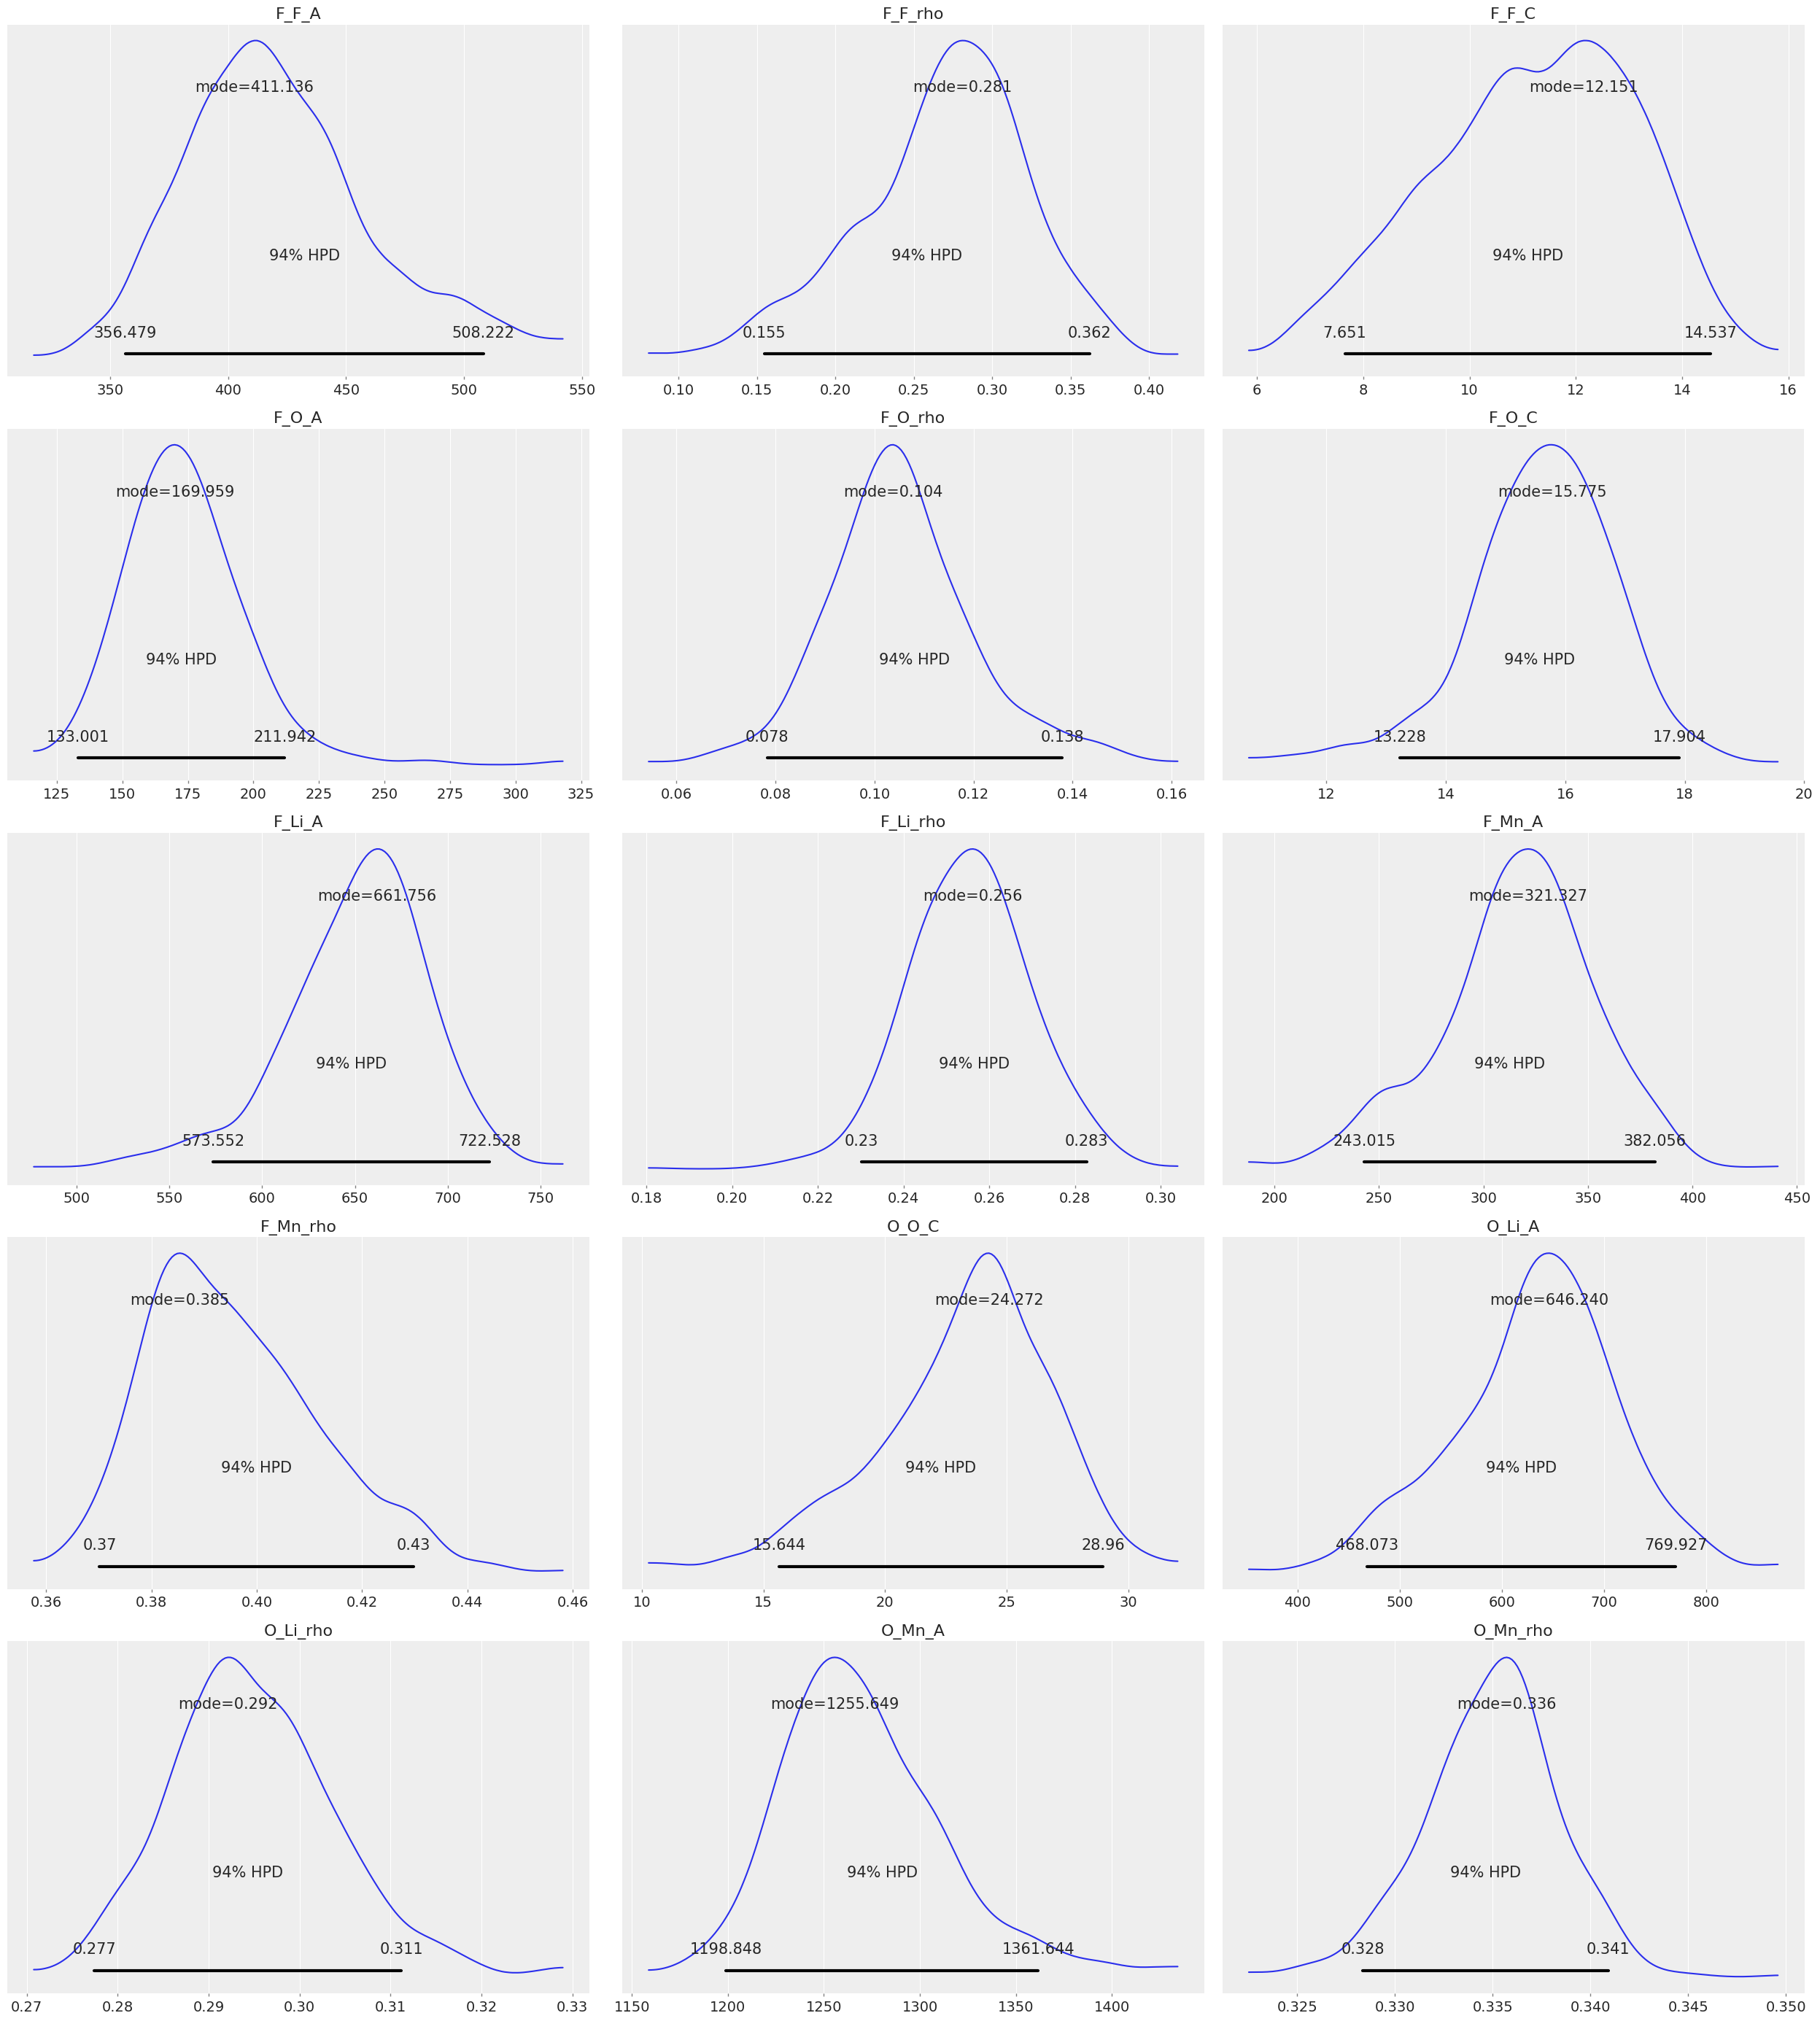

In [14]:
az.plot_posterior(trace, round_to = 3, point_estimate = 'mode')